In [1]:
import csv
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
%matplotlib inline

In [3]:
#['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']
log = pd.read_csv('data/driving_log.csv', usecols=['center', 'left', 'right', 'steering'])
log.head()

,center,left,right,steering
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0


In [4]:
def preprocess(image):
    #image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)[:,:,1]
    #image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = image[:,:,None]
    
    return image

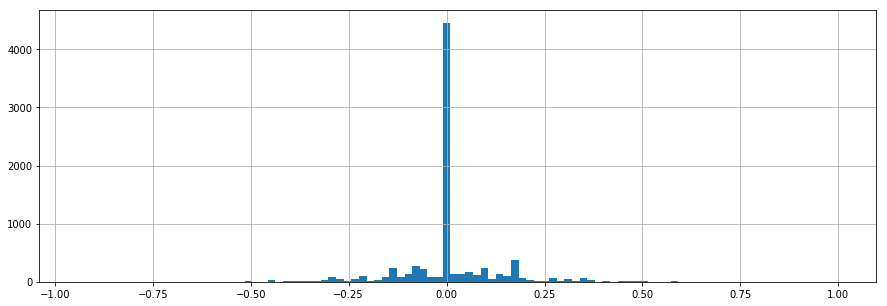

In [5]:
_ = log['steering'].hist(bins=100, figsize=(15,5))

In [6]:
log['steering'].describe()

count    8036.000000
mean        0.004070
std         0.128840
min        -0.942695
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: steering, dtype: float64

In [7]:
log_nonzero = log[log['steering']!=0]
log = log[log['steering']==0].sample(frac=0.1).append(log_nonzero)

In [8]:
log = log.reset_index()

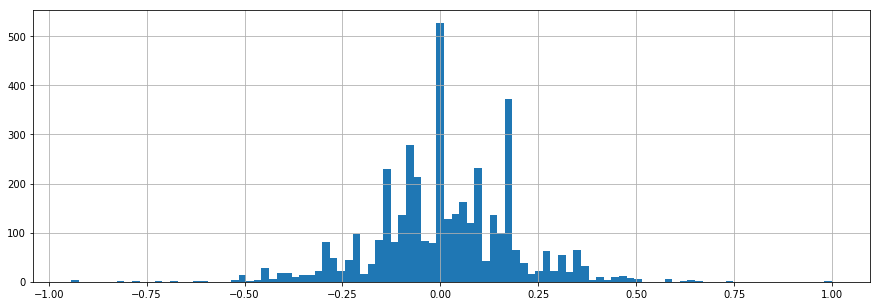

In [9]:
_ = log['steering'].hist(bins=100, figsize=(15,5))

In [10]:
images = []
steerings = []
correction = 0.08

for i in range(len(log)):
    filename_c = 'data/'+log['center'][i].strip()
    filename_l = 'data/'+log['left'][i].strip()
    filename_r = 'data/'+log['right'][i].strip()
    
    image_c = preprocess(mpimg.imread(filename_c))
    image_l = preprocess(mpimg.imread(filename_l))
    image_r = preprocess(mpimg.imread(filename_r))

    steering_c = log['steering'][i]
    steering_l = steering_c + correction
    steering_r = steering_c - correction
    
    images.extend([image_c, image_l, image_r])
    steerings.extend([steering_c, steering_l, steering_r])
    
    images.extend([cv2.flip(image_c, 1)[:,:,None], cv2.flip(image_l, 1)[:,:,None], cv2.flip(image_r, 1)[:,:,None]])
    steerings.extend([-steering_c, -steering_l, -steering_r])
    


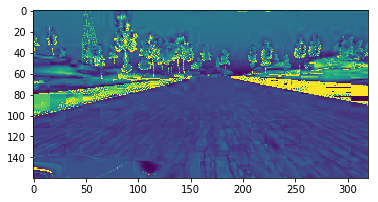

In [11]:
plt.imshow(images[310].squeeze())

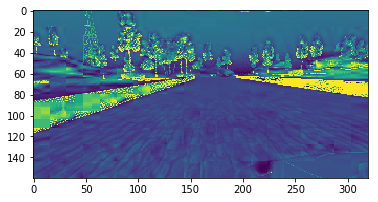

In [12]:
plt.imshow(images[311].squeeze())

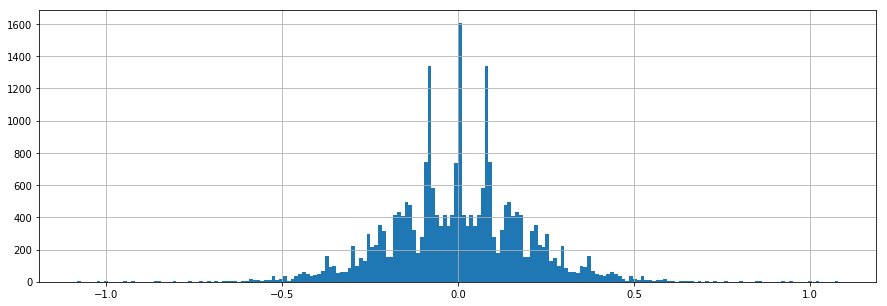

In [13]:
_ = pd.Series(steerings).hist(bins=200, figsize=(15,5))

In [14]:
X_train = np.array(images)
y_train = np.array(steerings)

In [15]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D
from keras.layers.convolutional import Convolution2D

Using TensorFlow backend.


In [16]:
model = Sequential()
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(160,320,1)))
model.add(Cropping2D(cropping=((70,25), (0,0)), input_shape=(160,320,1)))
#model.add(Convolution2D(24,5,5, subsample=(2,2), activation='relu'))
model.add(Flatten())
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
history_object = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=2) 

Train on 19732 samples, validate on 4934 samples
Epoch 1/2
19732/19732 [==============================] - 11s - loss: 0.2801 - val_loss: 0.0253

In [17]:
model.save('model.h5')

dict_keys(['val_loss', 'loss'])


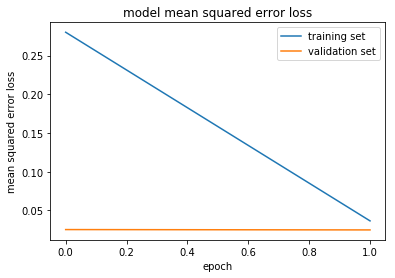

In [18]:
### print the keys contained in the history object
print(history_object.history.keys())
### plot the training and validation loss for each epoch

plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')